In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from geopy.geocoders import Nominatim
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
### WARNING : in env\Lib\site-packages\torch_geometric_temporal\nn\attention\tsagcn.py :
### change 'from torch_geometric.utils.to_dense_adj' by 'from torch_geometric.utils'
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import DCRNN, GConvGRU

from gnn_model import StationFlowGCN
from train_gnn import(
    train_gnn_model,
    eval_gnn_model,
)
from utils.station_network import StationNetworkSimul
from utils.data import get_degraded_network_loader, create_degraded_networks
from utils.metrics import MAPE_loss


In [3]:
def create_numbat_dataframe(data_dir, year, weekdays, sheet_name):
    df_numbat = pd.DataFrame()
    for weekday in weekdays:
        df_day = pd.read_excel(os.path.join(data_dir, f'NUMBAT {2023}', f'NBT{str(year)[-2:]}{weekday}_outputs.xlsx'), sheet_name=sheet_name,skiprows=2, header=0)
        df_day['weekday'] = weekday
        df_numbat = pd.concat((df_numbat, df_day))
    
    rename_dict = {
        'Early     ' : 'Early',
        'AM Peak   ' : 'AM Peak',
        'Midday    ' : 'Midday',
        'PM Peak   ' : 'PM Peak',
        'Evening   ' : 'Evening',
        'Late      ' : 'Late'
    }
    df_numbat = df_numbat.rename(columns=rename_dict)
    return df_numbat


In [4]:
data_dir = 'data/london/'

weekdays = {'MON':0,
 'TWT':1,
 'FRI':2,
 'SAT':3,
 'SUN':4}

In [5]:
df_numbat_station_entries = create_numbat_dataframe(data_dir, 2023, list(weekdays.keys()),'Station_Entries')
df_numbat_station_exits = create_numbat_dataframe(data_dir, 2023, list(weekdays.keys()), 'Station_Exits')
df_numbat_link_loads = create_numbat_dataframe(data_dir, 2023, list(weekdays.keys()), 'Link_Loads')

In [22]:
df_numbat_link_loads['weekday_idx'] = df_numbat_link_loads['weekday'].apply(lambda x : weekdays[x])
df_numbat_station_entries['weekday_idx'] = df_numbat_station_entries['weekday'].apply(lambda x : weekdays[x])
df_numbat_station_exits['weekday_idx'] = df_numbat_station_exits['weekday'].apply(lambda x : weekdays[x])

nlc_idx = {
    nlc : i for i, nlc in enumerate(df_numbat_station_entries['NLC'].unique())
}

df_numbat_station_entries['NLC_idx'] = df_numbat_station_entries['NLC'].apply(lambda x : nlc_idx[x])
df_numbat_station_exits['NLC_idx'] = df_numbat_station_exits['NLC'].apply(lambda x : nlc_idx[x])

df_numbat_link_loads['From NLC_idx'] = df_numbat_link_loads['From NLC'].apply(lambda x : nlc_idx[x])
df_numbat_link_loads['To NLC_idx'] = df_numbat_link_loads['To NLC'].apply(lambda x : nlc_idx[x])
df_numbat_link_loads['Link NLC_idx'] = list(zip(df_numbat_link_loads['From NLC_idx'], df_numbat_link_loads['To NLC_idx']))
df_numbat_link_loads['Link NLC_idx'] = df_numbat_link_loads['Link NLC_idx'].astype(str)

In [23]:
df_numbat_link_loads = df_numbat_link_loads.sort_values(by=['weekday_idx', 'From NLC_idx', 'To NLC_idx'])
df_numbat_station_entries = df_numbat_station_entries.sort_values(by=['weekday_idx', 'NLC_idx'])
df_numbat_station_exits = df_numbat_station_exits.sort_values(by=['weekday_idx', 'NLC_idx'])

In [24]:
df_quarter = pd.read_excel(os.path.join(data_dir, 'NBT22_Definitions_Published.xlsm'), header=0, sheet_name='Qhr')
df_quarter['Time'] = df_quarter['Time'].replace('2345-2400', '2345-0000')
time_to_quarter = {
    time : {'qhr' : i, 'hour' : hour, 'tb' : tb} for i, (time, tb, hour) in enumerate(df_quarter[['Time', 'Timeband', 'Hour']].values)
}

In [25]:
ordered_qhr = {qhr : qhr_idx for qhr_idx, qhr in enumerate(df_numbat_station_entries.columns[11:-3])}

In [26]:
df_numbat_link_loads

,Link,Line,Dir,Order,From NLC,From ASC,From Station,To NLC,To ASC,To Station,...,0345-0400,0400-0415,0415-0430,0430-0445,0445-0500,weekday,weekday_idx,From NLC_idx,To NLC_idx,Link NLC_idx
282,ABRd_DLR_IB>SHSd_DLR_IB@DLR,DLR,IB,17,750,ABRd,Abbey Road,749,SHSd,Stratford High Street,...,0.0,0.000000,0.000000,0.000000,0.000000,MON,0,0,383,"(0, 383)"
345,ABRd_DLR_OB>WHMu_DLR_OB@DLR,DLR,OB,31,750,ABRd,Abbey Road,757,WHMu,West Ham,...,0.0,0.000000,0.000000,0.000000,0.000000,MON,0,0,439,"(0, 439)"
718,ACCr_NLL_WB>SATr_NLL_WB@NLL,LO North London,WB,19,1404,ACCr,Acton Central,1452,SATr,South Acton,...,0.0,0.000000,0.000000,0.000000,0.000000,MON,0,1,354,"(1, 354)"
682,ACCr_NLL_EB>WJNu_NLL_EB@NLL,LO North London,EB,10,1404,ACCr,Acton Central,766,WJNu,Willesden Junction,...,0.0,0.000000,0.000000,0.000000,0.000000,MON,0,1,454,"(1, 454)"
430,AMLr_EZL_WB>EBYu_EZL_WB@EZL,Elizabeth Line,WB,26,3000,AMLr,Acton Main Line,560,EBYu,Ealing Broadway,...,0.0,2.760913,4.790109,4.790109,4.790109,MON,0,2,118,"(2, 118)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,CUSr_EZL_WB>CWXr_EZL_WB@EZL,Elizabeth Line,WB,17,6561,CUSr,Custom House EL,6560,CWXr,Canary Wharf EL,...,0.0,0.000000,0.000000,0.000000,0.000000,SUN,4,468,466,"(468, 466)"
389,CUSr_EZL_EB>WWCr_EZL_EB@EZL,Elizabeth Line,EB,27,6561,CUSr,Custom House EL,6562,WWCr,Woolwich EL,...,0.0,0.000000,0.000000,0.000000,0.000000,SUN,4,468,469,"(468, 469)"
390,WWCr_EZL_EB>ABWr_EZL_EB@EZL,Elizabeth Line,EB,28,6562,WWCr,Woolwich EL,5131,ABWr,Abbey Wood,...,0.0,0.000000,0.000000,0.000000,0.000000,SUN,4,469,467,"(469, 467)"
420,WWCr_EZL_WB>CUSr_EZL_WB@EZL,Elizabeth Line,WB,16,6562,WWCr,Woolwich EL,6561,CUSr,Custom House EL,...,0.0,0.000000,0.000000,0.000000,0.000000,SUN,4,469,468,"(469, 468)"


In [30]:
df_snap_station_entries = df_numbat_station_entries.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'NLC_idx'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_station_entries = df_snap_station_entries.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='NLC_idx', values='flow')

# Reset index to make it a proper DataFrame
df_snap_station_entries = df_snap_station_entries.reset_index()


df_snap_station_exits = df_numbat_station_exits.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'NLC_idx'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_station_exits = df_snap_station_exits.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='NLC_idx', values='flow')

# Reset index to make it a proper DataFrame
df_snap_station_exits = df_snap_station_exits.reset_index()

# df_snap_link_loads = df_numbat_link_loads.rename(columns=ordered_qhr).melt(
#     id_vars=['weekday_idx', 'Link NLC_idx'],
#     value_vars=ordered_qhr.values(),
#     var_name='quarter_hour_idx',
#     value_name='flow'
# )


# # Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
# df_snap_link_loads = df_snap_link_loads.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='Link NLC_idx', values='flow')

# # Reset index to make it a proper DataFrame
# df_snap_link_loads = df_snap_link_loads.reset_index()

In [49]:
station_entries = []
station_exits = []
station_features = []
for weekday in weekdays.keys():
    for qhr in time_to_quarter.keys():
        entries_day_qhr = df_numbat_station_entries[df_numbat_station_entries['weekday'] == weekday][['NLC', qhr]].sort_values(by=['NLC'])
        exits_day_qhr = df_numbat_station_exits[df_numbat_station_exits['weekday'] == weekday][['NLC', qhr]].sort_values(by=['NLC'])

        station_entries.append(
            np.array([entries for entries in entries_day_qhr[qhr]], dtype=float)
            # torch.tensor([entries for entries in entries_day_qhr[qhr]], dtype=float)
        )
        station_exits.append(
            np.array([exits for exits in exits_day_qhr[qhr]], dtype=float)
            # torch.tensor([exits for exits in exits_day_qhr[qhr]], dtype=float)
        )
        station_features.append(
            np.array([[
                time_to_quarter[qhr]['qhr'], time_to_quarter[qhr]['hour'], time_to_quarter[qhr]['tb'], weekdays[weekday]]]*len(exits_day_qhr), dtype=float)
            # torch.tensor([[time_to_quarter[qhr], weekdays[weekday]]]*len(exits_day_qhr)).float()
        )
        # station_features.append(
        #     np.array([i for i in range(len(exits_day_qhr))], dtype=int)
        #     # torch.tensor([[time_to_quarter[qhr], weekdays[weekday]]]*len(exits_day_qhr)).float()
        # )
    

In [37]:
station_entries = []
station_entries_features = []

station_exits = []
station_exits_features = []
# link_loads_features = []
lag = 4 
for i in range(len(df_snap_station_entries)-lag):
    station_entries.append(df_snap_station_entries.iloc[i+lag].to_numpy()[2:])
    station_exits.append(df_snap_station_exits.iloc[i+lag].to_numpy()[2:])
    # station_entries.append(df_pivoted.iloc[i+lag].to_numpy()[2:])
    entries_lag_features = df_snap_station_entries.iloc[i:i+lag].to_numpy().T[2:]
    exits_lag_features = df_snap_station_exits.iloc[i:i+lag].to_numpy().T[2:]
    
    calendar_features = np.array([df_snap_station_entries.iloc[i+lag].to_numpy()[:2] for _ in entries_lag_features])
    entries_features = np.concatenate((entries_lag_features, calendar_features), axis=1)
    exits_features = np.concatenate((exits_lag_features, calendar_features), axis=1)

    station_entries_features.append(entries_features)
    station_exits_features.append(exits_features)

In [38]:
edge_idx = [[], []]
for s,e in df_numbat_link_loads[df_numbat_link_loads['weekday'] == 'MON'][["From NLC_idx", "To NLC_idx"]].values:
    edge_idx[0].append(s)
    edge_idx[1].append(e)

edge_idx = np.array(edge_idx, dtype=int)
# edge_idx = torch.tensor(edge_idx, dtype=int)

In [40]:
numbat_2023_ent_ex_dataset = StaticGraphTemporalSignal(
    edge_index=edge_idx,
    features=station_entries_features,
    targets=station_entries,
    edge_weight=None,
    features_exits=station_exits_features,
    targets_exits=station_exits,
)

print(numbat_2023_ent_ex_dataset.snapshot_count)

numbat_train_dataset, numbat_test_dataset = temporal_signal_split(numbat_2023_ent_ex_dataset, train_ratio=0.8)
numbat_train_dataset, numbat_dev_dataset = temporal_signal_split(numbat_train_dataset, train_ratio=0.9)

476


In [45]:
numbat_2023_ent_ex_dataset[0].y

tensor([ 24.5171,  18.5561,  33.6321,  54.9666,   0.0000,   0.0000,  28.1840,
         33.8011,  12.7324,  63.3990,  63.9097,   0.0000,  62.3502,  27.2357,
         57.2829,   0.0000,  71.8947,  14.2642,   0.0000,  56.0223,  85.4564,
         59.3191,   8.4763, 542.9054,  24.0478,  63.6261,  31.3766,  31.5992,
         17.6066,   0.0000,   0.0000,  71.9427,  24.5181, 149.1166,   0.0000,
          0.0000,  17.8857,  75.7085,   6.3919,  73.5508,   0.0000,  39.2258,
          0.0000, 204.9486,  11.8049,  71.0352,  14.0393,  19.6204, 107.4702,
         23.3288,  43.1241,  34.9976,  89.3759, 270.3357,  54.5023,  47.1894,
         28.9542,   6.7871,  40.7186,  47.9842,  36.3364, 130.4057,  56.7758,
         58.7465,  29.5017,   8.3408,   7.7915,  12.7369,  38.9001, 106.9657,
         38.1802, 116.7749, 289.7263,  20.7771,  23.2375,  61.6243,  43.4570,
          0.0000, 174.2630,  46.2566,  19.4517,   6.9258,  56.0157,  42.5390,
         75.8054,   4.4822,  66.4566,  16.2739,  36.5764,   0.00

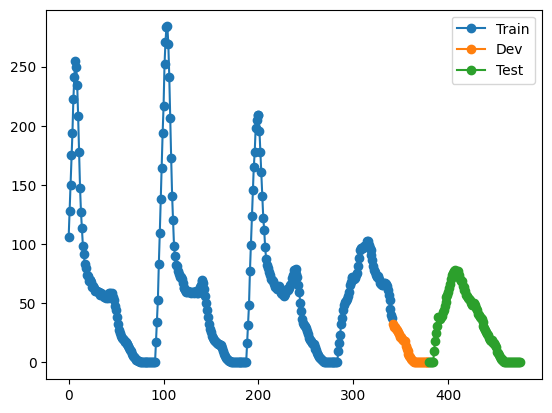

In [42]:
idx = random.randint(0, numbat_train_dataset[0].x.shape[0] -1)
train_val = [snapshot.y[idx] for snapshot in numbat_train_dataset]
dev_val = [snapshot.y[idx] for snapshot in numbat_dev_dataset]
test_val = [snapshot.y[idx] for snapshot in numbat_test_dataset]

num_snap_train = numbat_train_dataset.snapshot_count
num_snap_dev = numbat_dev_dataset.snapshot_count
num_snap_test = numbat_test_dataset.snapshot_count

plt.plot(range(num_snap_train),train_val, label='Train', marker='o')
plt.plot(range(num_snap_train, num_snap_train+ num_snap_dev),dev_val, label='Dev', marker='o')
plt.plot(range(num_snap_train+ num_snap_dev, num_snap_train+ num_snap_dev+num_snap_test),test_val, label='Test', marker='o')
plt.legend()
plt.show()

In [48]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        # self.recurrent = DCRNN(node_features, 32, 1)
        self.recurrent1 = DCRNN(node_features, 32, 1)
        # self.recurrent2 = DCRNN(32, 32, 1)
        # self.recurrent2 = DCRNN(32, 64, 1)
        # self.recurrent3 = DCRNN(64, 64, 1)
        # self.recurrent4 = DCRNN(64, 32, 1)
        self.station_entry_head = torch.nn.Sequential(
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),
        )

        self.station_exit_head = torch.nn.Sequential(
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),
        )

        # self.link_load_head = torch.nn.Sequential(
        #     torch.nn.Linear(2 * 32, 64),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(64, 32),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(32, 32),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(32, 1),
        #     torch.nn.ReLU(),)
        
        # self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent1(x, edge_index, edge_weight)
        h = F.relu(h)
        # h = self.recurrent2(h, edge_index, edge_weight)
        # h = F.relu(h)
        # h = self.recurrent3(h, edge_index, edge_weight)
        # h = F.relu(h)
        # h = self.recurrent4(h, edge_index, edge_weight)
        # h = F.relu(h)
        # h = self.linear(h)
        station_entries = self.station_entry_head(h)
        station_exits = self.station_exit_head(h)
        # link_loads = self.link_load_head(h)
        return station_entries, station_exits

Epoch 0


100%|██████████| 342/342 [00:02<00:00, 128.74it/s]


Train Loss - Entries 106.55406188964844; Exits: 106.26803588867188


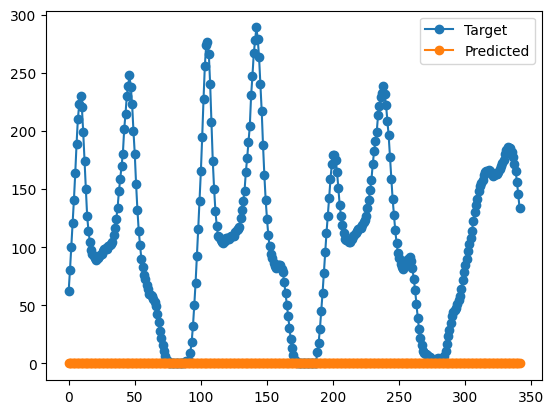

100%|██████████| 38/38 [00:00<00:00, 82.74it/s]


Dev Loss - Entries 46.39971160888672; Exits: 52.6335334777832


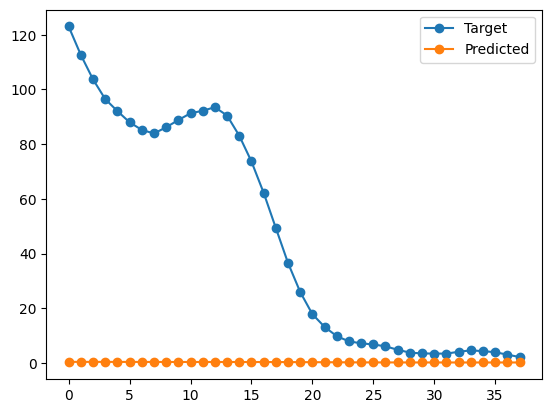

Epoch 1


100%|██████████| 342/342 [00:02<00:00, 131.16it/s]


Epoch 2


100%|██████████| 342/342 [00:02<00:00, 142.51it/s]


Epoch 3


100%|██████████| 342/342 [00:02<00:00, 148.97it/s]


Epoch 4


100%|██████████| 342/342 [00:02<00:00, 154.43it/s]


Epoch 5


100%|██████████| 342/342 [00:02<00:00, 154.04it/s]


Epoch 6


100%|██████████| 342/342 [00:02<00:00, 149.72it/s]


Epoch 7


100%|██████████| 342/342 [00:02<00:00, 154.47it/s]


Epoch 8


100%|██████████| 342/342 [00:02<00:00, 152.05it/s]


Epoch 9


100%|██████████| 342/342 [00:02<00:00, 149.14it/s]


Epoch 10


100%|██████████| 342/342 [00:02<00:00, 154.19it/s]


Train Loss - Entries 104.70439147949219; Exits: 105.05817413330078


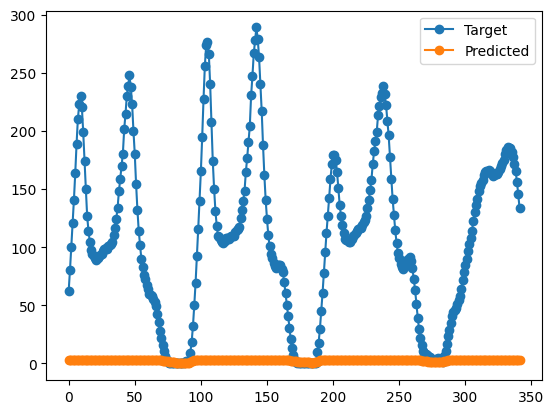

100%|██████████| 38/38 [00:00<00:00, 133.75it/s]


Dev Loss - Entries 45.51817321777344; Exits: 51.697513580322266


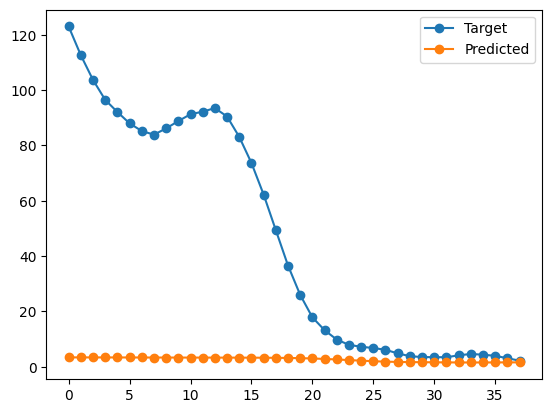

Epoch 11


100%|██████████| 342/342 [00:02<00:00, 147.21it/s]


Epoch 12


100%|██████████| 342/342 [00:02<00:00, 155.23it/s]


Epoch 13


100%|██████████| 342/342 [00:02<00:00, 154.59it/s]


Epoch 14


100%|██████████| 342/342 [00:02<00:00, 151.26it/s]


Epoch 15


100%|██████████| 342/342 [00:02<00:00, 150.25it/s]


Epoch 16


100%|██████████| 342/342 [00:02<00:00, 149.50it/s]


Epoch 17


100%|██████████| 342/342 [00:02<00:00, 136.24it/s]


Epoch 18


100%|██████████| 342/342 [00:02<00:00, 142.18it/s]


Epoch 19


100%|██████████| 342/342 [00:02<00:00, 148.35it/s]


Epoch 20


100%|██████████| 342/342 [00:02<00:00, 153.05it/s]


Train Loss - Entries 101.44099426269531; Exits: 101.28887939453125


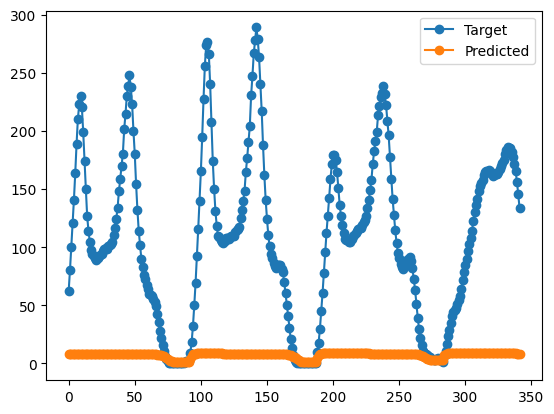

100%|██████████| 38/38 [00:00<00:00, 139.51it/s]


Dev Loss - Entries 44.54610061645508; Exits: 49.230010986328125


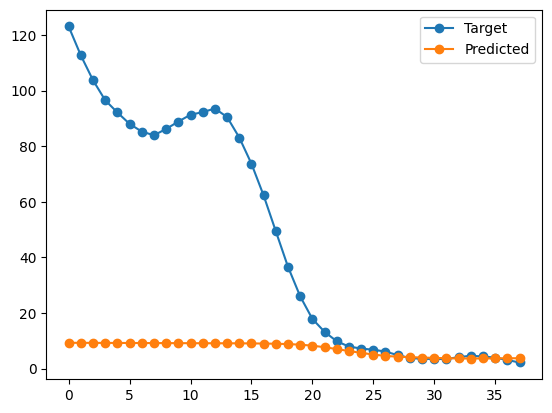

Epoch 21


100%|██████████| 342/342 [00:02<00:00, 149.88it/s]


Epoch 22


100%|██████████| 342/342 [00:02<00:00, 157.71it/s]


Epoch 23


100%|██████████| 342/342 [00:02<00:00, 157.21it/s]


Epoch 24


100%|██████████| 342/342 [00:02<00:00, 151.04it/s]


Epoch 25


100%|██████████| 342/342 [00:02<00:00, 154.47it/s]


Epoch 26


100%|██████████| 342/342 [00:02<00:00, 154.42it/s]


Epoch 27


100%|██████████| 342/342 [00:02<00:00, 144.93it/s]


Epoch 28


100%|██████████| 342/342 [00:02<00:00, 156.65it/s]


Epoch 29


100%|██████████| 342/342 [00:02<00:00, 154.21it/s]


Epoch 30


100%|██████████| 342/342 [00:02<00:00, 149.21it/s]


Train Loss - Entries 96.59266662597656; Exits: 95.19205474853516


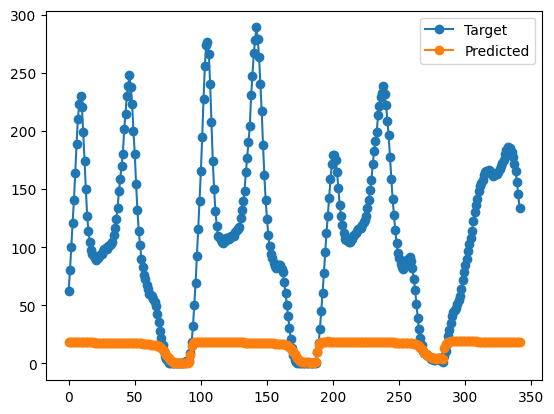

100%|██████████| 38/38 [00:00<00:00, 116.58it/s]


Dev Loss - Entries 44.4593505859375; Exits: 46.02930450439453


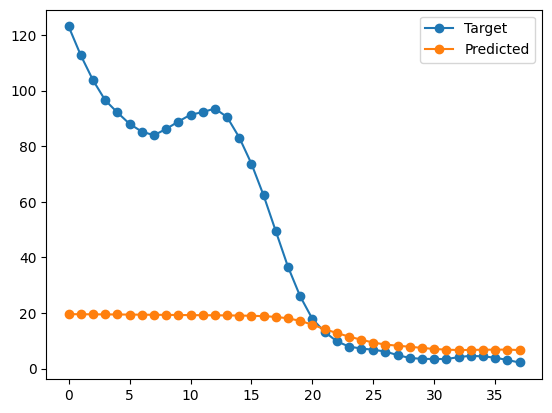

Epoch 31


100%|██████████| 342/342 [00:02<00:00, 131.35it/s]


Epoch 32


100%|██████████| 342/342 [00:02<00:00, 153.11it/s]


Epoch 33


100%|██████████| 342/342 [00:02<00:00, 154.22it/s]


Epoch 34


100%|██████████| 342/342 [00:02<00:00, 151.71it/s]


Epoch 35


100%|██████████| 342/342 [00:02<00:00, 154.54it/s]


Epoch 36


100%|██████████| 342/342 [00:02<00:00, 131.86it/s]


Epoch 37


100%|██████████| 342/342 [00:02<00:00, 142.09it/s]


Epoch 38


100%|██████████| 342/342 [00:02<00:00, 151.39it/s]


Epoch 39


100%|██████████| 342/342 [00:02<00:00, 155.30it/s]


Epoch 40


100%|██████████| 342/342 [00:02<00:00, 149.57it/s]


Train Loss - Entries 91.50749969482422; Exits: 90.19988250732422


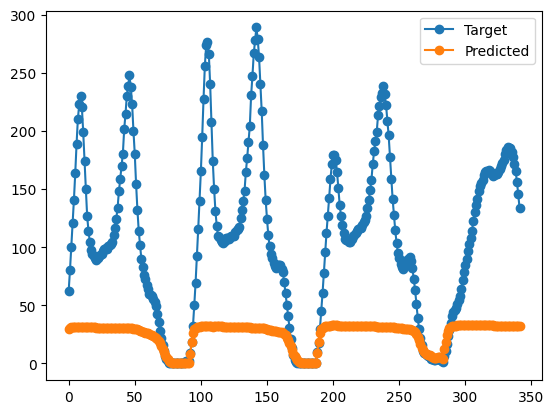

100%|██████████| 38/38 [00:00<00:00, 138.59it/s]


Dev Loss - Entries 46.43400955200195; Exits: 45.26240158081055


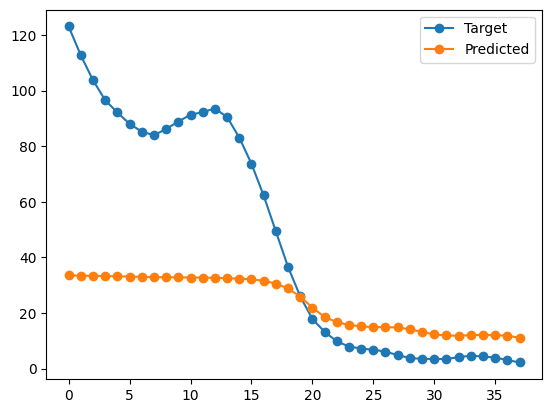

Epoch 41


100%|██████████| 342/342 [00:02<00:00, 149.49it/s]


Epoch 42


100%|██████████| 342/342 [00:02<00:00, 154.05it/s]


Epoch 43


100%|██████████| 342/342 [00:02<00:00, 133.54it/s]


Epoch 44


100%|██████████| 342/342 [00:02<00:00, 128.34it/s]


Epoch 45


100%|██████████| 342/342 [00:02<00:00, 137.37it/s]


Epoch 46


100%|██████████| 342/342 [00:02<00:00, 139.03it/s]


Epoch 47


100%|██████████| 342/342 [00:02<00:00, 148.05it/s]


Epoch 48


100%|██████████| 342/342 [00:02<00:00, 152.94it/s]


Epoch 49


100%|██████████| 342/342 [00:02<00:00, 148.70it/s]


Epoch 50


100%|██████████| 342/342 [00:02<00:00, 153.23it/s]


Train Loss - Entries 87.73632049560547; Exits: 87.85008239746094


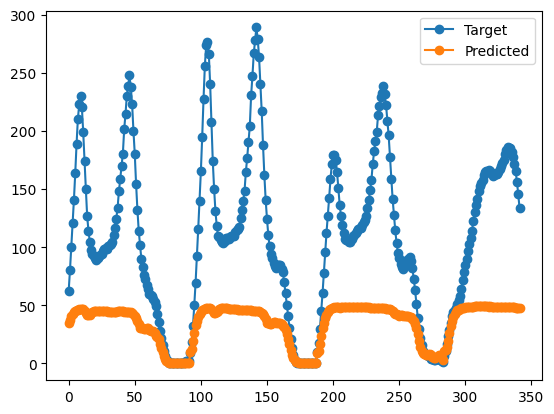

100%|██████████| 38/38 [00:00<00:00, 121.13it/s]


Dev Loss - Entries 50.72407531738281; Exits: 47.96592712402344


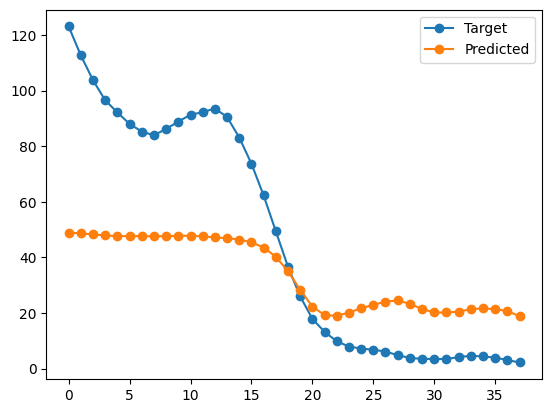

Epoch 51


100%|██████████| 342/342 [00:04<00:00, 79.99it/s] 


Epoch 52


100%|██████████| 342/342 [00:02<00:00, 117.05it/s]


Epoch 53


100%|██████████| 342/342 [00:02<00:00, 140.73it/s]


Epoch 54


100%|██████████| 342/342 [00:02<00:00, 152.16it/s]


Epoch 55


100%|██████████| 342/342 [00:02<00:00, 152.21it/s]


Epoch 56


100%|██████████| 342/342 [00:02<00:00, 153.98it/s]


Epoch 57


100%|██████████| 342/342 [00:02<00:00, 154.61it/s]


Epoch 58


100%|██████████| 342/342 [00:02<00:00, 152.54it/s]


Epoch 59


100%|██████████| 342/342 [00:02<00:00, 150.16it/s]


Epoch 60


100%|██████████| 342/342 [00:02<00:00, 154.83it/s]


Train Loss - Entries 86.26262664794922; Exits: 87.31866455078125


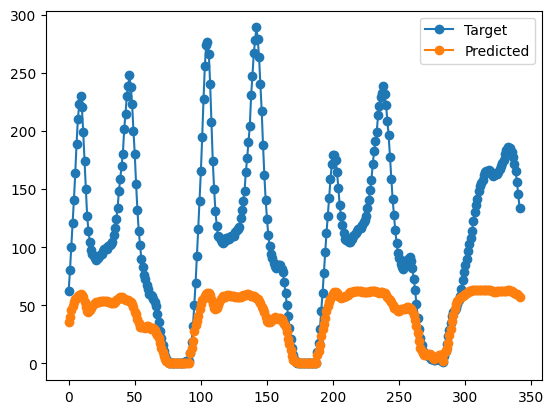

100%|██████████| 38/38 [00:00<00:00, 92.68it/s]


Dev Loss - Entries 53.76938247680664; Exits: 49.47785186767578


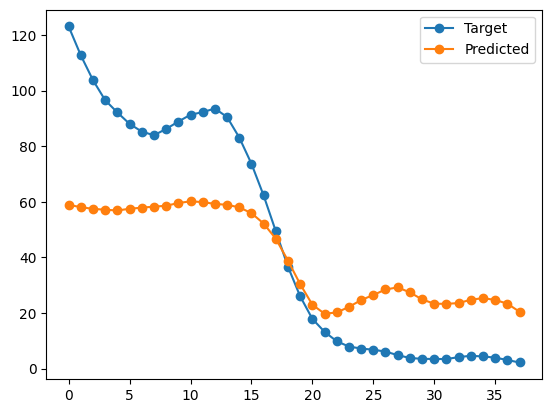

Epoch 61


100%|██████████| 342/342 [00:02<00:00, 150.80it/s]


Epoch 62


100%|██████████| 342/342 [00:02<00:00, 146.08it/s]


Epoch 63


100%|██████████| 342/342 [00:02<00:00, 152.10it/s]


Epoch 64


100%|██████████| 342/342 [00:02<00:00, 151.01it/s]


Epoch 65


100%|██████████| 342/342 [00:02<00:00, 148.64it/s]


Epoch 66


100%|██████████| 342/342 [00:02<00:00, 154.22it/s]


Epoch 67


100%|██████████| 342/342 [00:02<00:00, 151.08it/s]


Epoch 68


100%|██████████| 342/342 [00:02<00:00, 144.85it/s]


Epoch 69


100%|██████████| 342/342 [00:02<00:00, 150.64it/s]


Epoch 70


100%|██████████| 342/342 [00:02<00:00, 151.46it/s]


Train Loss - Entries 85.67279052734375; Exits: 87.01787567138672


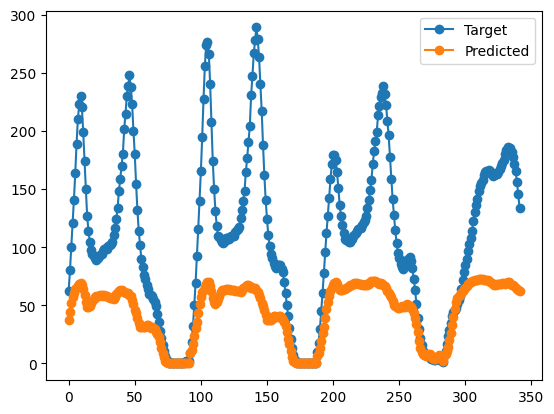

100%|██████████| 38/38 [00:00<00:00, 123.26it/s]


Dev Loss - Entries 52.02699279785156; Exits: 47.115570068359375


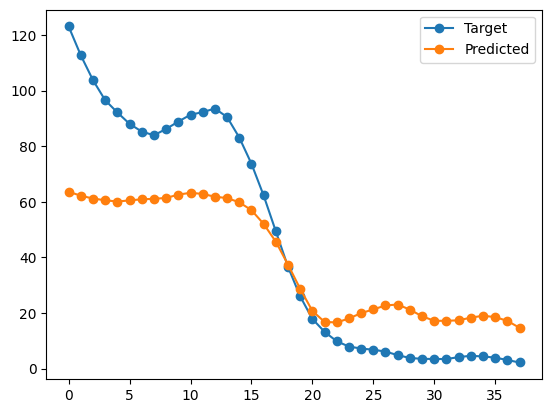

Epoch 71


100%|██████████| 342/342 [00:02<00:00, 136.34it/s]


Epoch 72


100%|██████████| 342/342 [00:02<00:00, 141.89it/s]


Epoch 73


100%|██████████| 342/342 [00:02<00:00, 151.04it/s]


Epoch 74


100%|██████████| 342/342 [00:02<00:00, 151.67it/s]


Epoch 75


100%|██████████| 342/342 [00:02<00:00, 145.49it/s]


Epoch 76


100%|██████████| 342/342 [00:02<00:00, 150.71it/s]


Epoch 77


100%|██████████| 342/342 [00:02<00:00, 152.21it/s]


Epoch 78


100%|██████████| 342/342 [00:02<00:00, 145.75it/s]


Epoch 79


100%|██████████| 342/342 [00:02<00:00, 151.31it/s]


Epoch 80


100%|██████████| 342/342 [00:02<00:00, 152.28it/s]


Train Loss - Entries 85.48149871826172; Exits: 86.6334457397461


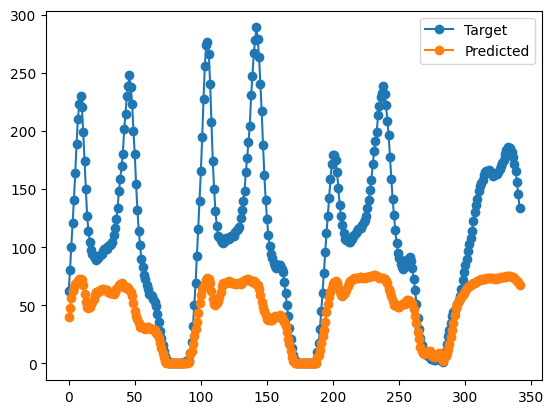

100%|██████████| 38/38 [00:00<00:00, 125.94it/s]


Dev Loss - Entries 50.906795501708984; Exits: 46.10382843017578


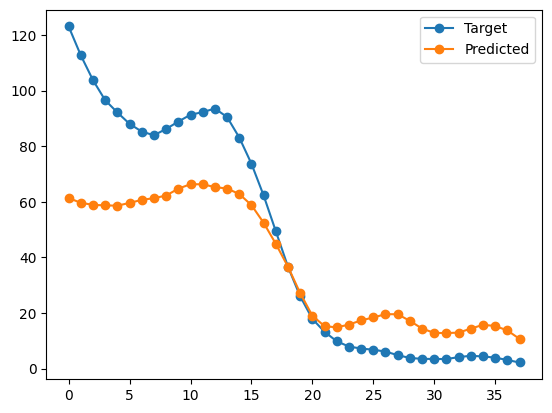

Epoch 81


100%|██████████| 342/342 [00:02<00:00, 150.30it/s]


Epoch 82


100%|██████████| 342/342 [00:02<00:00, 147.13it/s]


Epoch 83


100%|██████████| 342/342 [00:02<00:00, 150.74it/s]


Epoch 84


100%|██████████| 342/342 [00:02<00:00, 152.04it/s]


Epoch 85


100%|██████████| 342/342 [00:02<00:00, 149.00it/s]


Epoch 86


100%|██████████| 342/342 [00:02<00:00, 155.08it/s]


Epoch 87


100%|██████████| 342/342 [00:02<00:00, 154.25it/s]


Epoch 88


100%|██████████| 342/342 [00:02<00:00, 151.12it/s]


Epoch 89


100%|██████████| 342/342 [00:03<00:00, 111.37it/s]


Epoch 90


100%|██████████| 342/342 [00:02<00:00, 130.23it/s]


Train Loss - Entries 85.14715576171875; Exits: 86.54741668701172


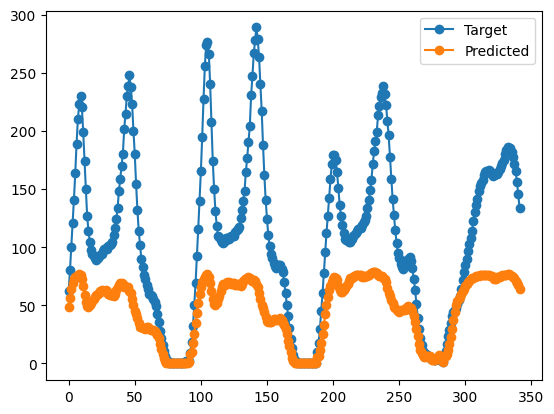

100%|██████████| 38/38 [00:00<00:00, 123.80it/s]


Dev Loss - Entries 50.18060302734375; Exits: 46.212501525878906


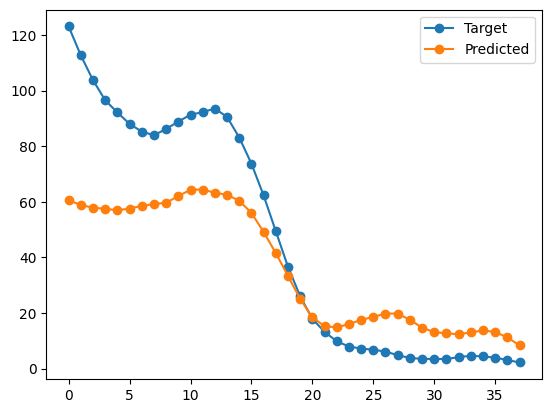

Epoch 91


100%|██████████| 342/342 [00:02<00:00, 150.34it/s]


Epoch 92


100%|██████████| 342/342 [00:02<00:00, 146.91it/s]


Epoch 93


100%|██████████| 342/342 [00:02<00:00, 153.11it/s]


Epoch 94


100%|██████████| 342/342 [00:02<00:00, 151.54it/s]


Epoch 95


100%|██████████| 342/342 [00:02<00:00, 149.88it/s]


Epoch 96


100%|██████████| 342/342 [00:02<00:00, 152.08it/s]


Epoch 97


100%|██████████| 342/342 [00:02<00:00, 151.33it/s]


Epoch 98


100%|██████████| 342/342 [00:02<00:00, 146.18it/s]


Epoch 99


100%|██████████| 342/342 [00:02<00:00, 136.20it/s]


Epoch 100


100%|██████████| 342/342 [00:02<00:00, 151.29it/s]


Train Loss - Entries 84.99665069580078; Exits: 86.2841567993164


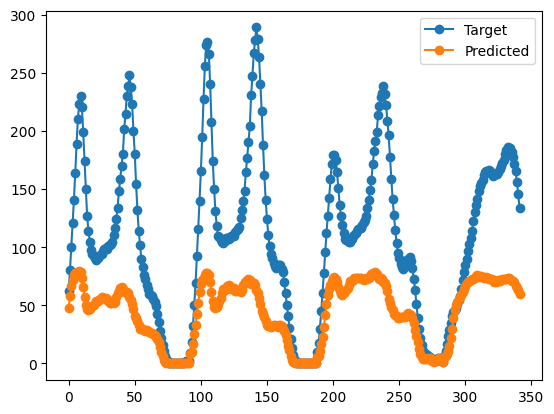

100%|██████████| 38/38 [00:00<00:00, 136.01it/s]


Dev Loss - Entries 49.8917236328125; Exits: 46.102909088134766


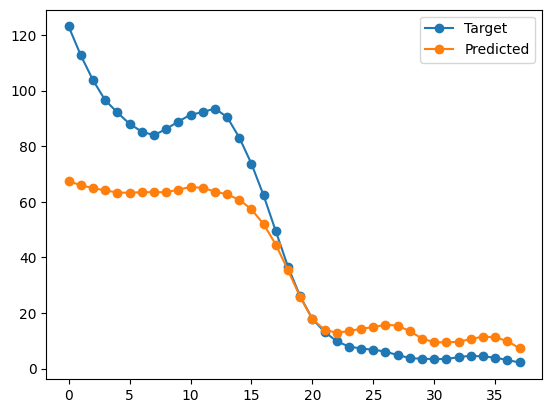

Epoch 101


100%|██████████| 342/342 [00:02<00:00, 152.45it/s]


Epoch 102


100%|██████████| 342/342 [00:02<00:00, 144.03it/s]


Epoch 103


100%|██████████| 342/342 [00:02<00:00, 150.06it/s]


Epoch 104


100%|██████████| 342/342 [00:02<00:00, 121.28it/s]


Epoch 105


100%|██████████| 342/342 [00:02<00:00, 124.21it/s]


Epoch 106


100%|██████████| 342/342 [00:02<00:00, 147.49it/s]


Epoch 107


100%|██████████| 342/342 [00:02<00:00, 144.07it/s]


Epoch 108


100%|██████████| 342/342 [00:02<00:00, 153.40it/s]


Epoch 109


100%|██████████| 342/342 [00:02<00:00, 149.16it/s]


Epoch 110


100%|██████████| 342/342 [00:02<00:00, 153.42it/s]


Train Loss - Entries 85.05986785888672; Exits: 86.4373779296875


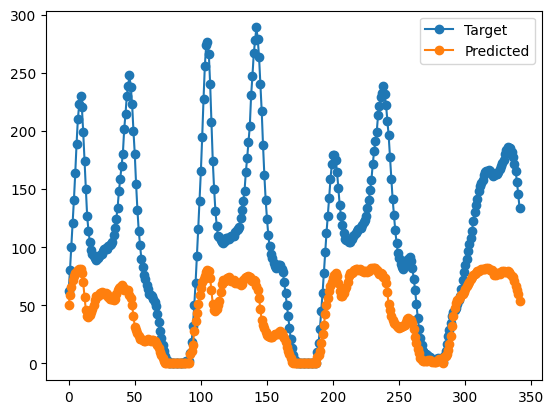

100%|██████████| 38/38 [00:00<00:00, 81.75it/s]


Dev Loss - Entries 49.94908905029297; Exits: 46.732452392578125


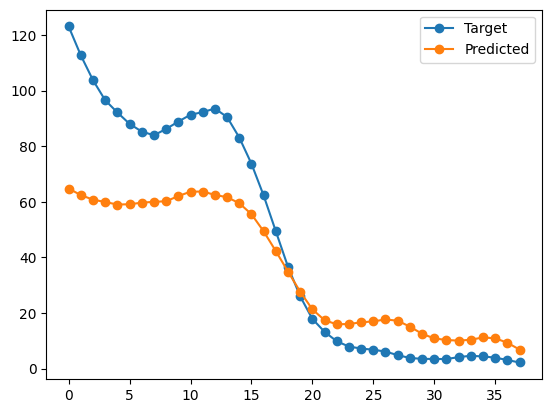

Epoch 111


100%|██████████| 342/342 [00:02<00:00, 156.81it/s]


Epoch 112


100%|██████████| 342/342 [00:02<00:00, 155.65it/s]


Epoch 113


100%|██████████| 342/342 [00:02<00:00, 152.89it/s]


Epoch 114


100%|██████████| 342/342 [00:02<00:00, 152.49it/s]


Epoch 115


100%|██████████| 342/342 [00:02<00:00, 154.96it/s]


Epoch 116


100%|██████████| 342/342 [00:02<00:00, 150.56it/s]


Epoch 117


100%|██████████| 342/342 [00:02<00:00, 155.94it/s]


Epoch 118


100%|██████████| 342/342 [00:02<00:00, 145.21it/s]


Epoch 119


100%|██████████| 342/342 [00:02<00:00, 142.62it/s]


Epoch 120


100%|██████████| 342/342 [00:02<00:00, 157.12it/s]


Train Loss - Entries 84.79386901855469; Exits: 85.97037506103516


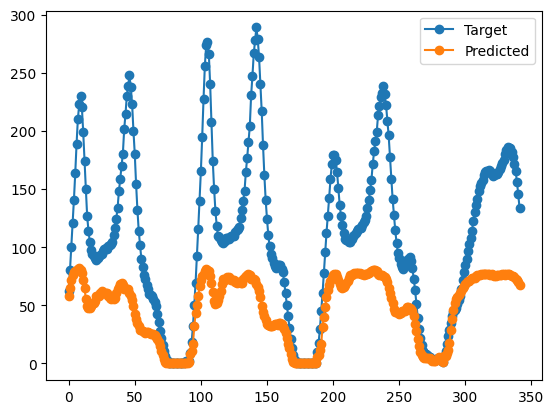

100%|██████████| 38/38 [00:00<00:00, 138.55it/s]


Dev Loss - Entries 53.0362434387207; Exits: 48.915836334228516


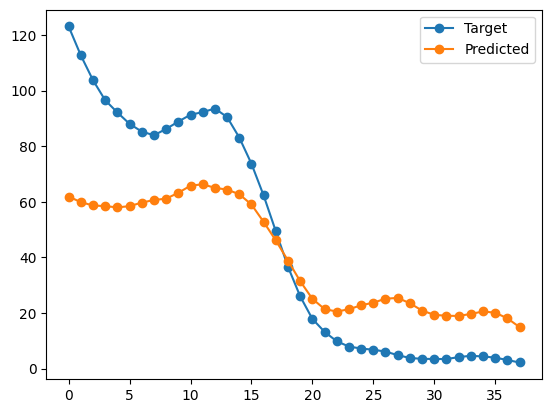

Epoch 121


100%|██████████| 342/342 [00:02<00:00, 141.74it/s]


Epoch 122


100%|██████████| 342/342 [00:02<00:00, 154.11it/s]


Epoch 123


100%|██████████| 342/342 [00:02<00:00, 158.47it/s]


Epoch 124


100%|██████████| 342/342 [00:02<00:00, 152.75it/s]


Epoch 125


100%|██████████| 342/342 [00:02<00:00, 157.46it/s]


Epoch 126


100%|██████████| 342/342 [00:02<00:00, 156.80it/s]


Epoch 127


100%|██████████| 342/342 [00:02<00:00, 152.44it/s]


Epoch 128


100%|██████████| 342/342 [00:02<00:00, 157.48it/s]


Epoch 129


100%|██████████| 342/342 [00:02<00:00, 157.46it/s]


Epoch 130


100%|██████████| 342/342 [00:02<00:00, 154.81it/s]


Train Loss - Entries 84.86188507080078; Exits: 86.19407653808594


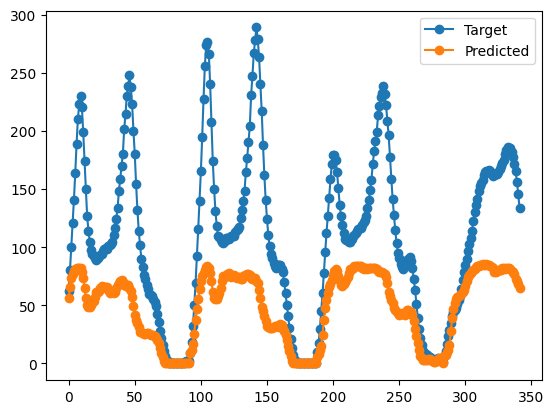

100%|██████████| 38/38 [00:00<00:00, 118.22it/s]


Dev Loss - Entries 47.13116455078125; Exits: 43.96723175048828


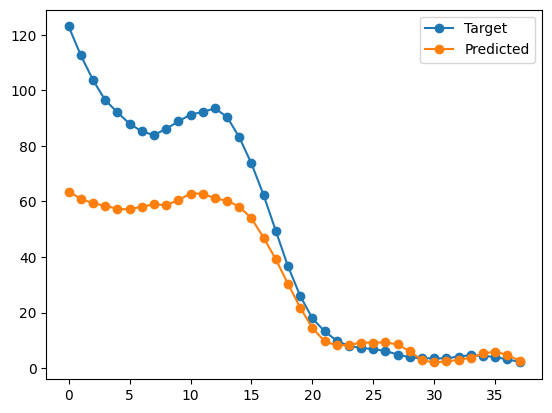

Epoch 131


100%|██████████| 342/342 [00:02<00:00, 158.96it/s]


Epoch 132


100%|██████████| 342/342 [00:02<00:00, 158.84it/s]


Epoch 133


100%|██████████| 342/342 [00:02<00:00, 158.40it/s]


Epoch 134


100%|██████████| 342/342 [00:02<00:00, 158.88it/s]


Epoch 135


100%|██████████| 342/342 [00:02<00:00, 159.58it/s]


Epoch 136


100%|██████████| 342/342 [00:02<00:00, 148.66it/s]


Epoch 137


100%|██████████| 342/342 [00:02<00:00, 151.24it/s]


Epoch 138


100%|██████████| 342/342 [00:02<00:00, 148.11it/s]


Epoch 139


100%|██████████| 342/342 [00:02<00:00, 150.76it/s]


Epoch 140


100%|██████████| 342/342 [00:02<00:00, 156.10it/s]


Train Loss - Entries 84.76896667480469; Exits: 85.8471450805664


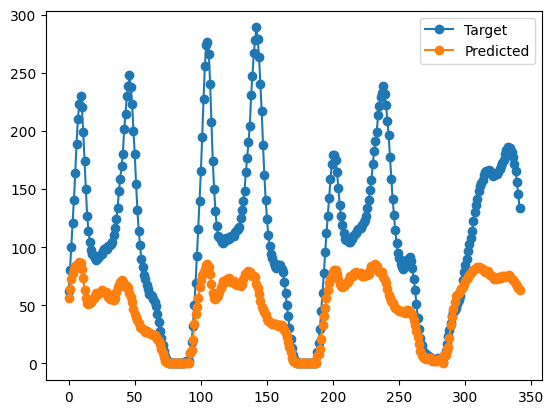

100%|██████████| 38/38 [00:00<00:00, 104.88it/s]


Dev Loss - Entries 48.497711181640625; Exits: 45.544158935546875


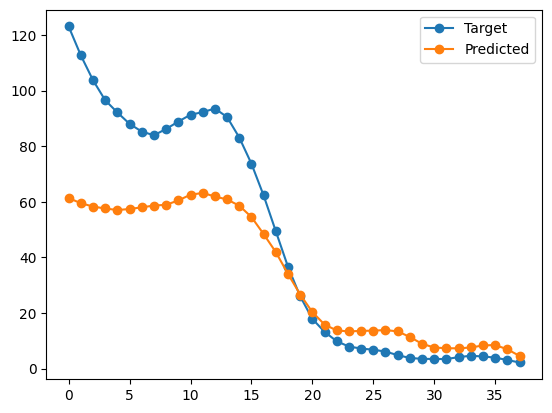

Epoch 141


100%|██████████| 342/342 [00:02<00:00, 159.62it/s]


Epoch 142


100%|██████████| 342/342 [00:02<00:00, 152.76it/s]


Epoch 143


100%|██████████| 342/342 [00:02<00:00, 135.60it/s]


Epoch 144


100%|██████████| 342/342 [00:02<00:00, 143.89it/s]


Epoch 145


100%|██████████| 342/342 [00:02<00:00, 139.20it/s]


Epoch 146


100%|██████████| 342/342 [00:02<00:00, 156.11it/s]


Epoch 147


100%|██████████| 342/342 [00:02<00:00, 157.52it/s]


Epoch 148


100%|██████████| 342/342 [00:02<00:00, 152.19it/s]


Epoch 149


100%|██████████| 342/342 [00:02<00:00, 158.90it/s]


Epoch 150


100%|██████████| 342/342 [00:02<00:00, 157.64it/s]


Train Loss - Entries 85.019287109375; Exits: 86.1020278930664


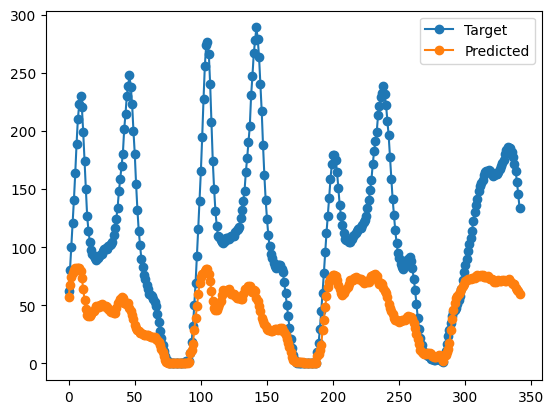

100%|██████████| 38/38 [00:00<00:00, 101.65it/s]


Dev Loss - Entries 48.24614334106445; Exits: 45.46326446533203


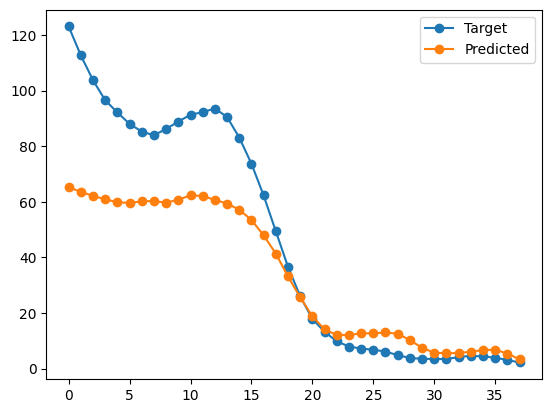

Epoch 151


100%|██████████| 342/342 [00:02<00:00, 157.69it/s]


Epoch 152


100%|██████████| 342/342 [00:02<00:00, 154.49it/s]


Epoch 153


100%|██████████| 342/342 [00:02<00:00, 151.85it/s]


Epoch 154


100%|██████████| 342/342 [00:02<00:00, 159.15it/s]


Epoch 155


100%|██████████| 342/342 [00:02<00:00, 158.62it/s]


Epoch 156


100%|██████████| 342/342 [00:02<00:00, 152.17it/s]


Epoch 157


100%|██████████| 342/342 [00:02<00:00, 158.96it/s]


Epoch 158


100%|██████████| 342/342 [00:02<00:00, 156.74it/s]


Epoch 159


100%|██████████| 342/342 [00:02<00:00, 139.26it/s]


Epoch 160


100%|██████████| 342/342 [00:02<00:00, 144.87it/s]


Train Loss - Entries 84.61930084228516; Exits: 85.9325180053711


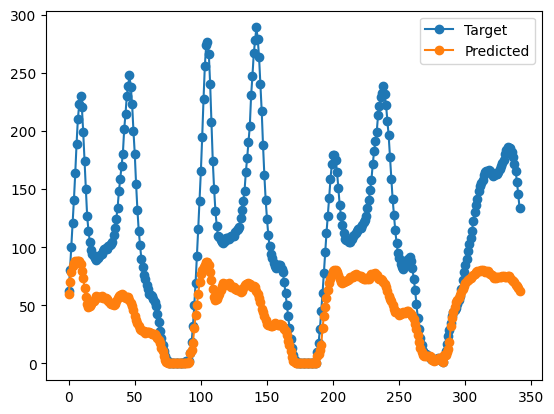

100%|██████████| 38/38 [00:00<00:00, 114.94it/s]


Dev Loss - Entries 47.240753173828125; Exits: 44.94160461425781


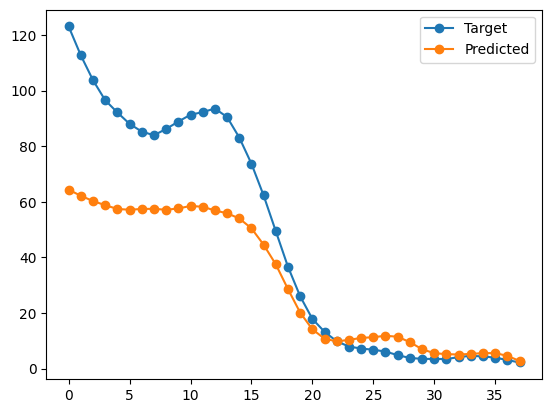

Epoch 161


100%|██████████| 342/342 [00:02<00:00, 136.27it/s]


Epoch 162


100%|██████████| 342/342 [00:02<00:00, 131.28it/s]


Epoch 163


100%|██████████| 342/342 [00:02<00:00, 123.23it/s]


Epoch 164


100%|██████████| 342/342 [00:02<00:00, 135.06it/s]


Epoch 165


100%|██████████| 342/342 [00:02<00:00, 114.95it/s]


Epoch 166


100%|██████████| 342/342 [00:02<00:00, 137.03it/s]


Epoch 167


100%|██████████| 342/342 [00:02<00:00, 139.87it/s]


Epoch 168


100%|██████████| 342/342 [00:02<00:00, 148.05it/s]


Epoch 169


100%|██████████| 342/342 [00:02<00:00, 144.41it/s]


Epoch 170


100%|██████████| 342/342 [00:04<00:00, 76.27it/s] 


Train Loss - Entries 84.54309844970703; Exits: 85.75131225585938


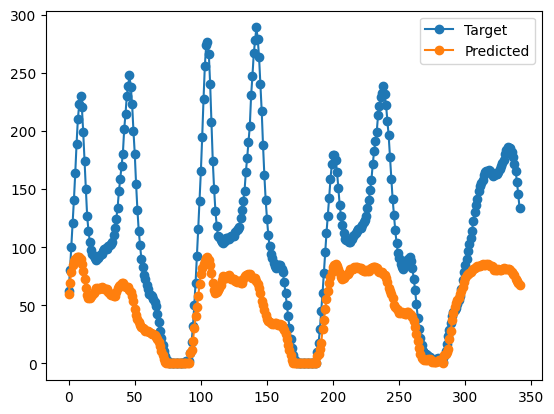

100%|██████████| 38/38 [00:00<00:00, 63.88it/s]


Dev Loss - Entries 47.12459945678711; Exits: 45.818843841552734


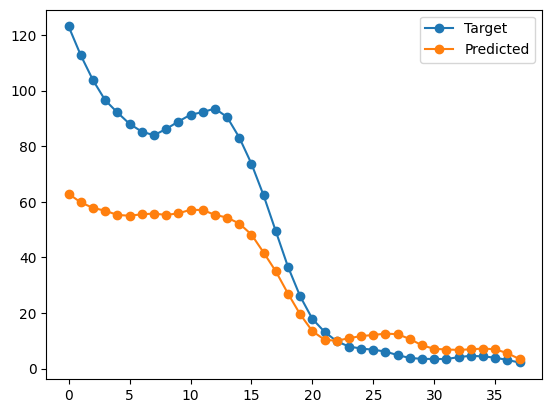

Epoch 171


100%|██████████| 342/342 [00:03<00:00, 85.89it/s] 


Epoch 172


100%|██████████| 342/342 [00:02<00:00, 135.15it/s]


Epoch 173


100%|██████████| 342/342 [00:02<00:00, 138.41it/s]


Epoch 174


100%|██████████| 342/342 [00:02<00:00, 118.25it/s]


Epoch 175


100%|██████████| 342/342 [00:02<00:00, 135.29it/s]


Epoch 176


100%|██████████| 342/342 [00:03<00:00, 112.88it/s]


Epoch 177


100%|██████████| 342/342 [00:02<00:00, 129.41it/s]


Epoch 178


100%|██████████| 342/342 [00:02<00:00, 128.45it/s]


Epoch 179


100%|██████████| 342/342 [00:02<00:00, 137.61it/s]


Epoch 180


100%|██████████| 342/342 [00:02<00:00, 140.57it/s]


Train Loss - Entries 84.53340148925781; Exits: 85.61383819580078


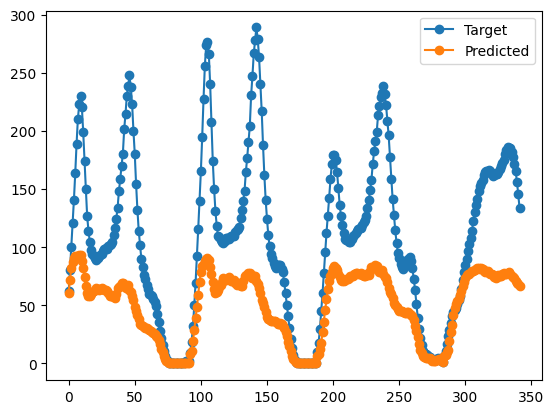

100%|██████████| 38/38 [00:00<00:00, 104.47it/s]


Dev Loss - Entries 44.8302116394043; Exits: 45.30119705200195


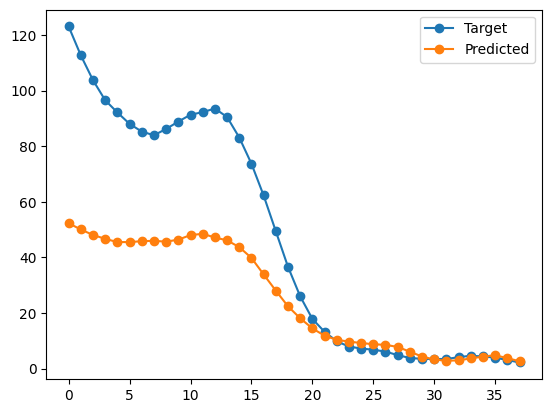

Epoch 181


100%|██████████| 342/342 [00:02<00:00, 130.25it/s]


Epoch 182


100%|██████████| 342/342 [00:02<00:00, 145.78it/s]


Epoch 183


100%|██████████| 342/342 [00:02<00:00, 159.00it/s]


Epoch 184


100%|██████████| 342/342 [00:02<00:00, 156.42it/s]


Epoch 185


100%|██████████| 342/342 [00:02<00:00, 150.69it/s]


Epoch 186


100%|██████████| 342/342 [00:02<00:00, 164.71it/s]


Epoch 187


100%|██████████| 342/342 [00:02<00:00, 156.87it/s]


Epoch 188


100%|██████████| 342/342 [00:02<00:00, 157.68it/s]


Epoch 189


100%|██████████| 342/342 [00:02<00:00, 163.75it/s]


Epoch 190


100%|██████████| 342/342 [00:02<00:00, 132.05it/s]


Train Loss - Entries 84.41929626464844; Exits: 85.70441436767578


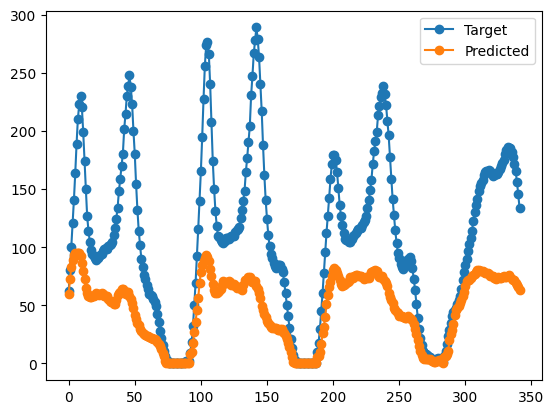

100%|██████████| 38/38 [00:00<00:00, 88.40it/s] 


Dev Loss - Entries 46.54120635986328; Exits: 44.909305572509766


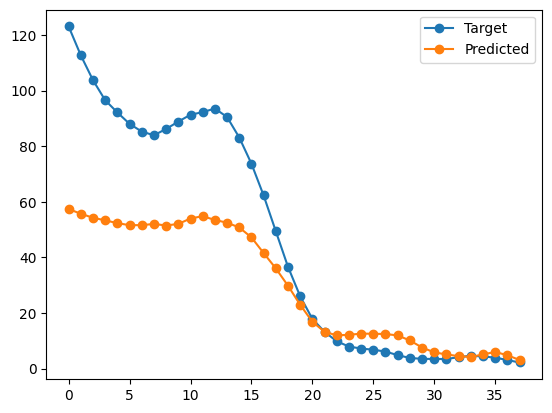

Epoch 191


100%|██████████| 342/342 [00:02<00:00, 130.92it/s]


Epoch 192


100%|██████████| 342/342 [00:02<00:00, 139.21it/s]


Epoch 193


100%|██████████| 342/342 [00:04<00:00, 74.31it/s] 


Epoch 194


100%|██████████| 342/342 [00:03<00:00, 113.27it/s]


Epoch 195


100%|██████████| 342/342 [00:02<00:00, 126.82it/s]


Epoch 196


100%|██████████| 342/342 [00:02<00:00, 139.78it/s]


Epoch 197


100%|██████████| 342/342 [00:02<00:00, 138.13it/s]


Epoch 198


100%|██████████| 342/342 [00:02<00:00, 125.02it/s]


Epoch 199


100%|██████████| 342/342 [00:02<00:00, 162.25it/s]


In [55]:
model = RecurrentGCN(node_features = lag + 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion =torch.nn.L1Loss()
epochs = 200

num_snap_train = numbat_train_dataset.snapshot_count
idx_plot = 0
for epoch in range(epochs):
    ### TRAIN

    model.train()
    print("Epoch", epoch)
    entries_train_loss = 0
    exits_train_loss = 0
    entries_pred_plot = np.empty((num_snap_train, numbat_dev_dataset[0].x.shape[0]))
    entries_true_plot = np.empty((num_snap_train, numbat_dev_dataset[0].x.shape[0]))
    for time, snapshot in tqdm(enumerate(numbat_train_dataset), total=num_snap_train):
        pred_entries, pred_exits = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        entries_train_loss = entries_train_loss + criterion(pred_entries, snapshot.y)
        exits_train_loss = exits_train_loss + criterion(pred_exits, snapshot.targets_exits)
        entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
        entries_true_plot[time] = snapshot.y.numpy()
    
    entries_train_loss = entries_train_loss / num_snap_train
    exits_train_loss = exits_train_loss / num_snap_train
    
    train_loss = entries_train_loss + exits_train_loss
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch%10 == 0:
        # print("Train Loss:", train_loss.item())
        print("Train Loss - Entries {}; Exits: {}".format(entries_train_loss.item(), exits_train_loss.item()))
        plt.plot(range(numbat_train_dataset.snapshot_count),np.mean(entries_true_plot, axis=1), label='Target', marker='o')
        plt.plot(range(numbat_train_dataset.snapshot_count),np.mean(entries_pred_plot, axis=1), label='Predicted', marker='o')
        plt.legend()
        plt.show()

    ### EVAL
        model.eval()
        entries_dev_loss = 0
        exits_dev_loss = 0
        entries_pred_plot = np.empty((num_snap_dev, numbat_dev_dataset[0].x.shape[0]))
        entries_true_plot = np.empty((num_snap_dev, numbat_dev_dataset[0].x.shape[0]))
        for time, snapshot in tqdm(enumerate(numbat_dev_dataset), total=num_snap_dev):
            pred_entries, pred_exits = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
            entries_true_plot[time] = snapshot.y.numpy()

            entries_dev_loss = entries_dev_loss + criterion(pred_entries, snapshot.y)
            exits_dev_loss = exits_dev_loss + criterion(pred_exits, snapshot.targets_exits)
        
        entries_dev_loss = entries_dev_loss / num_snap_dev
        exits_dev_loss = exits_dev_loss / num_snap_dev
        print("Dev Loss - Entries {}; Exits: {}".format(entries_dev_loss.item(), exits_dev_loss.item()))
        plt.plot(range(num_snap_dev),np.mean(entries_true_plot, axis=1), label='Target', marker='o')
        plt.plot(range(num_snap_dev),np.mean(entries_pred_plot, axis=1), label='Predicted', marker='o')
        plt.legend()
        plt.show()

In [39]:
model.eval()
cost = 0
num_snapshot = numbat_test_dataset.snapshot_count
for time, snapshot in tqdm(enumerate(numbat_test_dataset), total=num_snapshot):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / num_snapshot
cost = cost.item()
print("MSE: {:.4f}".format(cost))

100%|██████████| 96/96 [00:00<00:00, 104.40it/s]

MSE: 25673.4395
